# Rev 노트: Figure 6 연도별 SLR 비교
- turbo 계열 팔레트, 최근 연도 강조
- 컬러바/보조축 구성 정리
- station 선택 변수화 (TARGET_STATION)



In [1]:
# 스타일 및 공통 설정
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update({
    'axes.labelsize': 11,
    'axes.titlesize': 11,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
    'font.family': ['Helvetica', 'NanumSquare'],
})
from matplotlib import cm, colors
from pathlib import Path




In [26]:
# 구성 파라미터
MAIN_STATION = 'Ulleungdo'
SUPP_STATIONS = ['Seogwipo', 'Jeju']
GENERATE_COMBINED_SUPP = True
YEAR_CMAP_NAME = 'turbo'
BASE_LINEWIDTH = 1.2
RECENT_LINEWIDTH = 1.2
BASE_ALPHA = 0.5
RECENT_ALPHA = 0.5
RECENT_HIGHLIGHT_START = None  # None이면 강조 해제
SHOW_MARKERS = False
OUTPUT_DIR = 'LaTeX/Figures'
SUPP_OUTPUT_DIR = 'LaTeX/SUPP'



In [14]:
# 구성 파라미터
TARGET_STATION = 'Ulleungdo'  # 본문 Figure 6는 'Ulleungdo'로 설정
YEAR_CMAP_NAME = 'turbo'
BASE_LINEWIDTH = 1.2
# RECENT_LINEWIDTH = 2.0
RECENT_LINEWIDTH = BASE_LINEWIDTH
BASE_ALPHA = 0.45
# RECENT_ALPHA = 0.75
RECENT_ALPHA = BASE_ALPHA
# RECENT_HIGHLIGHT_START = 2010  # None이면 강조 해제
RECENT_HIGHLIGHT_START = None  # None이면 강조 해제
SHOW_MARKERS = True
OUTPUT_DIR = 'LaTeX/Figures'



In [20]:
# 구성 파라미터
TARGET_STATION = 'Jeju'  # 본문 Figure 6는 'Ulleungdo'로 설정
YEAR_CMAP_NAME = 'turbo'
BASE_LINEWIDTH = 1.2
# RECENT_LINEWIDTH = 2.0
RECENT_LINEWIDTH = BASE_LINEWIDTH
BASE_ALPHA = 0.45
# RECENT_ALPHA = 0.75
RECENT_ALPHA = BASE_ALPHA
# RECENT_HIGHLIGHT_START = 2010  # None이면 강조 해제
RECENT_HIGHLIGHT_START = None  # None이면 강조 해제
SHOW_MARKERS = True
OUTPUT_DIR = 'LaTeX/Figures'



In [21]:
import os
import time
import string

import numpy as np
import pandas as pd

from datetime import datetime, timedelta
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates

from tqdm import tqdm

# Font
from matplotlib import font_manager
font_path = "/workspace/fonts/"
font_list = os.listdir(font_path)
for font_file in font_list:
    try:
        font_manager.fontManager.addfont(font_path + font_file)
    except:
        raise Exception(f"Cannot Load {font_path+font_file}")

In [22]:
path = 'Data/'
flist = sorted([x for x in os.listdir('./Data/')if x.endswith('txt')])

df_oris = []
for f in tqdm(flist):
    df_ori = pd.read_csv(path+f, sep='\t', header=None)
    df_oris.append(df_ori)

df_ress = []
for f in tqdm(flist):
    df_res = pd.read_parquet(f'Data_mid/{f[8:-4]}_CEEMDAN_2048_0.6.parquet')
    df_ress.append(df_res)


df_ress2 = []
for f in tqdm(flist):
    df_res = pd.read_parquet(f'Data_mid/{f[8:-4]}_EEMD_2048_0.6.parquet')
    df_ress2.append(df_res)

100%|██████████| 21/21 [00:00<00:00, 871.80it/s]


In [38]:
# --------- helper functions ---------
station_file_map = {f[8:-4]: f for f in flist}

norm_cache = {}

def load_station_data(station):
    if station not in station_file_map:
        raise ValueError(f"Station {station} not found")
    idx = flist.index(station_file_map[station])
    df1 = df_oris[idx]
    df2 = df_ress[idx]
    df3 = df_ress2[idx]
    x_ori = df1.iloc[:, -1] - df1.iloc[0, -1]
    x_cee = df2.iloc[:, -1] - df2.iloc[0, -1]
    x_eem = df3.iloc[:, -1] - df3.iloc[0, -1]
    x_ori.index = x_cee.index
    temp = pd.DataFrame({'year': x_ori.index.year, 'value': x_ori.values})
    yearly_mean = temp.groupby('year').mean()['value'].values
    x_smo = smoothen(np.arange(len(yearly_mean)), yearly_mean, p=12)
    x_ori.loc[:] = x_smo[1] - x_smo[1][0]
    lin_slr = df.loc[station, 'yearly slr (mm/yr) Linear'] / 12 / 10
    x_lin = x_ori.copy()
    x_lin.iloc[:] = lin_slr
    x_lin = x_lin.cumsum()
    seasonal = pd.DataFrame({
        'year': x_ori.index.year,
        'month': x_ori.index.month,
        'value': df1.iloc[:, -1]
    }).groupby(['year', 'month']).mean()
    data = {
        'station': station,
        'x_ori': x_ori,
        'x_cee': x_cee,
        'x_eem': x_eem,
        'x_lin': x_lin,
        'seasonal': seasonal
    }
    return data


def plot_station_axes(ax_cum, ax_season, data, cmap_name=YEAR_CMAP_NAME):
    station = data['station']
    ax_cum.text(0.02, 0.92, station, transform=ax_cum.transAxes, size=11, weight='bold')
    ax_cum.plot(data['x_ori'].index, data['x_ori'].values, color=MEAN_COLOR, label='Yearly mean', linewidth=1.0)
    ax_cum.plot(data['x_cee'].index, data['x_cee'].values, color=CEEMDAN_COLOR, label='CEEMDAN', linewidth=1.2)
    ax_cum.plot(data['x_eem'].index, data['x_eem'].values, color=EEMD_COLOR, label='EEMD', linewidth=1.2)
    ax_cum.plot(data['x_lin'].index, data['x_lin'].values, color=LINEAR_COLOR, label='Linear', linewidth=1.1)
    ax_cum.set_xlabel('Year')
    ax_cum.set_ylabel('Cumulative Sea Level Change (cm)')
    ax_cum.grid(alpha=0.25, linewidth=0.6)
    ax_cum.legend(loc='upper left', frameon=False, fontsize=9)

    seasonal = data['seasonal']
    years = seasonal.index.get_level_values('year').unique().to_numpy()
    months = seasonal.index.get_level_values('month').unique()
    norm = norm_cache.get((years.min(), years.max()))
    if norm is None:
        norm = colors.Normalize(vmin=years.min(), vmax=years.max())
        norm_cache[(years.min(), years.max())] = norm
    year_cmap = cm.get_cmap(cmap_name)

    for year in years:
        series = seasonal.xs(year)
        series = series - series.iloc[0]
        color = year_cmap(norm(year))
        ax_season.plot(series.index, series.values, color=color,
                       linewidth=BASE_LINEWIDTH, alpha=BASE_ALPHA)
    ax_season.set_xlim(1, 12)
    ax_season.set_xticks([1, 4, 7, 10])
    ax_season.set_xticklabels(['Jan', 'Apr', 'Jul', 'Oct'])
    ax_season.set_ylabel('Relative Sea Level (cm)')
    ax_season.set_xlabel('Month')
    ax_season.grid(alpha=0.25, linewidth=0.6)

    sm = cm.ScalarMappable(norm=norm, cmap=year_cmap)
    cbar = plt.colorbar(sm, ax=ax_season, pad=0.03)
    ticks = np.linspace(years.min(), years.max(), 5, dtype=int)
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([str(t) for t in ticks])
    cbar.set_label('Year')


def save_station_figure(station, output_dir):
    data = load_station_data(station)
    fig, axes = plt.subplots(1, 2, figsize=(8.4, 3.2), dpi=320)
    plot_station_axes(axes[0], axes[1], data)
    leg = axes[0].legend(
        loc='upper left',
        bbox_to_anchor=(0.0, 0.93),  # y 값을 더 낮추면 아래로 이동
        frameon=False,
        fontsize=9,
        handlelength=1.6
    )

    fig.tight_layout()
    output_dir.mkdir(parents=True, exist_ok=True)
    fig.savefig(output_dir / f"Figure6_yearly_SLRs_comparison_{station}.pdf", format='pdf', dpi=320, bbox_inches='tight')
    plt.close(fig)


def save_combined_supp(stations, output_dir):
    if not stations:
        return
    output_dir.mkdir(parents=True, exist_ok=True)
    n = len(stations)
    fig, axes = plt.subplots(2, n, figsize=(8.4 * n / 2, 3.2 * 2), dpi=320)
    print(axes)
    axes = axes.flatten()
    if n == 1:
        axes = [axes[0], axes[1]]
    for idx, station in enumerate(stations):
        data = load_station_data(station)
        ax_cum = axes[2 * idx]
        ax_season = axes[2 * idx + 1]
        plot_station_axes(ax_cum, ax_season, data)
        ax_cum.set_title(f'{station} cumulative')
        ax_season.set_title(f'{station} monthly')
        leg = ax_cum.legend(
            loc='upper left',
            bbox_to_anchor=(0.0, 0.93),  # y 값을 더 낮추면 아래로 이동
            frameon=False,
            fontsize=9,
            handlelength=1.6
        )

    fig.tight_layout()
    fig.savefig(output_dir / 'FigureS_yearly_SLRs_comparison_stations.pdf', format='pdf', dpi=320, bbox_inches='tight')
    plt.close(fig)

# --------- main execution ---------
main_output = Path(OUTPUT_DIR)
supp_output = Path(SUPP_OUTPUT_DIR)

save_station_figure(MAIN_STATION, main_output)

if SUPP_STATIONS:
    for st in SUPP_STATIONS:
        save_station_figure(st, supp_output)

if GENERATE_COMBINED_SUPP:
    save_combined_supp(SUPP_STATIONS, supp_output)



/tmp/ipykernel_21355/2336010713.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  year_cmap = cm.get_cmap(cmap_name)
/tmp/ipykernel_21355/2336010713.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  year_cmap = cm.get_cmap(cmap_name)
/tmp/ipykernel_21355/2336010713.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  year_cmap = cm.get_cmap(cmap_name)


[[<Axes: > <Axes: >]
 [<Axes: > <Axes: >]]


/tmp/ipykernel_21355/2336010713.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  year_cmap = cm.get_cmap(cmap_name)
/tmp/ipykernel_21355/2336010713.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  year_cmap = cm.get_cmap(cmap_name)


In [28]:
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

def smoothen(x,y,p=10, kind='cubic'): # 'linear', 'nearest', 'zero', 'slinear', 'quadratic', 'cubic', 'previous', 'next'
    f = interp1d(x, y, kind=kind)
    xn = np.linspace(min(x), max(x), num=len(x)*p, endpoint=True)
    return xn, f(xn)


/tmp/ipykernel_21355/1506940703.py:72: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  year_cmap = cm.get_cmap(YEAR_CMAP_NAME)
/tmp/ipykernel_21355/1506940703.py:100: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


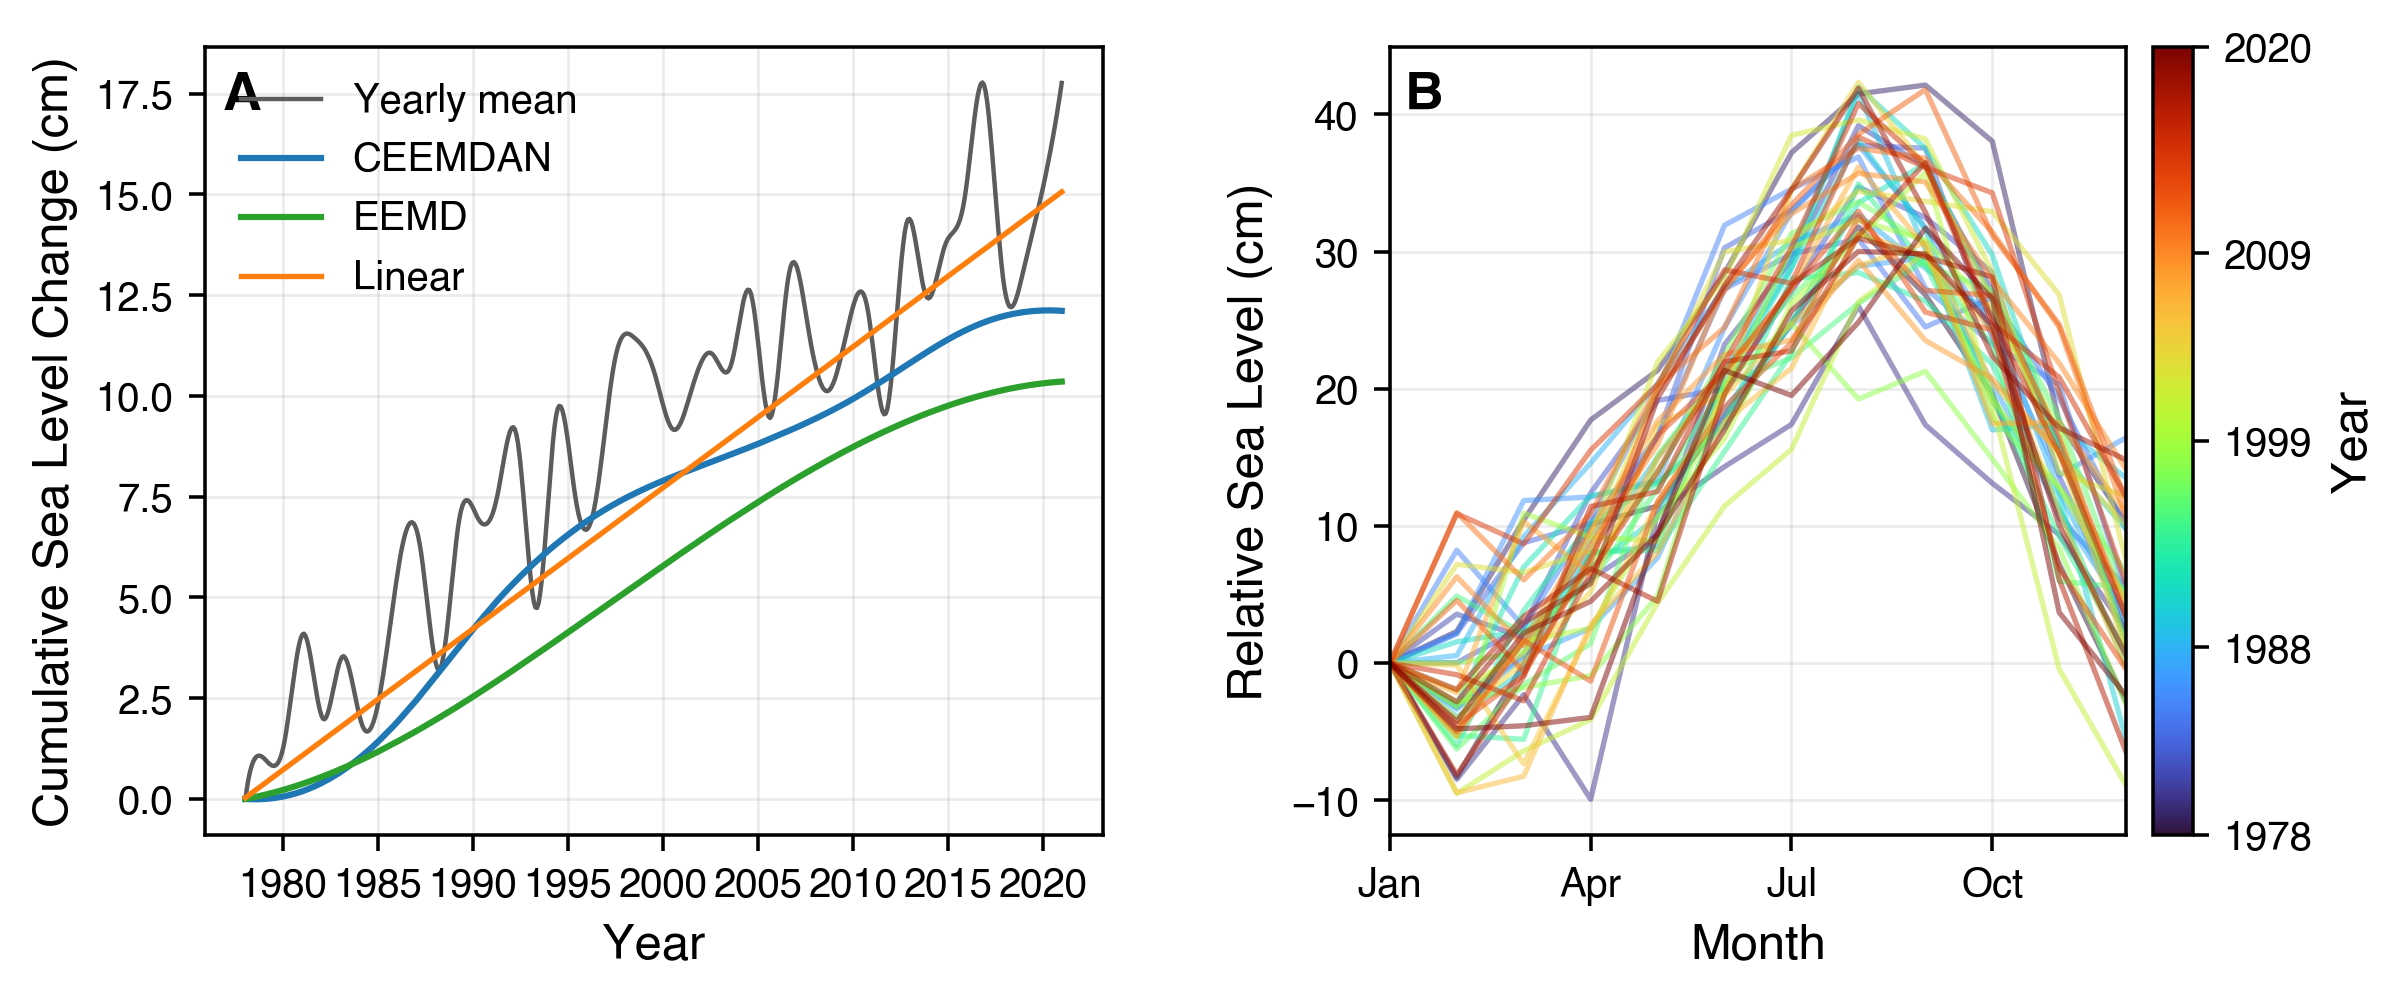

In [29]:
# 선 색상 정의
MEAN_COLOR = '#5c5c5c'
CEEMDAN_COLOR = '#1f77b4'
EEMD_COLOR = '#2ca02c'
LINEAR_COLOR = '#ff7f0e'

station_file = f"Monthly_{TARGET_STATION}.txt"
if station_file not in flist:
    raise ValueError(f"Station file {station_file} not found in Data/ directory")
index = flist.index(station_file)
station = TARGET_STATION

# Data Processing
df1 = df_oris[index]
df2 = df_ress[index]
df3 = df_ress2[index]

x_ori = df1.iloc[:, -1] - df1.iloc[0, -1]
x_cee = df2.iloc[:, -1] - df2.iloc[0, -1]
x_eem = df3.iloc[:, -1] - df3.iloc[0, -1]
x_ori.index = x_cee.index

# 연도별 smoothing (연평균 누적)
temp = pd.DataFrame({'year': x_ori.index.year, 'value': x_ori.values})
yearly_mean = temp.groupby('year').mean()['value'].values
x_smo = smoothen(np.arange(len(yearly_mean)), yearly_mean, p=12)
x_ori.loc[:] = x_smo[1] - x_smo[1][0]

lin_slr = df.loc[station, 'yearly slr (mm/yr) Linear'] / 12 / 10
x_lin = x_ori.copy()
x_lin.iloc[:] = lin_slr
x_lin = x_lin.cumsum()

# Plotting
X_SIZE, Y_SIZE = 4.2, 3.2
N_ROW, N_COL = 1, 2
DPI = 320

fig = plt.figure(figsize=(X_SIZE * N_COL, Y_SIZE * N_ROW), dpi=DPI)
spec = gridspec.GridSpec(ncols=N_COL, nrows=N_ROW, figure=fig, wspace=0.32)

# Panel A
aio = 0
ax0 = fig.add_subplot(spec[0, 0])
ax0.text(0.02, 0.92, string.ascii_uppercase[aio], transform=ax0.transAxes, size=12, weight='bold')
if SHOW_MARKERS:
    ax0.plot(x_ori.index, x_ori.values, color=MEAN_COLOR, label='Yearly mean', marker='o', markevery=12, markersize=4.2, linewidth=1.0)
else:
    ax0.plot(x_ori.index, x_ori.values, color=MEAN_COLOR, label='Yearly mean', linewidth=1.0)
ax0.plot(x_cee.index, x_cee.values, color=CEEMDAN_COLOR, label='CEEMDAN', linewidth=1.4)
ax0.plot(x_eem.index, x_eem.values, color=EEMD_COLOR, label='EEMD', linewidth=1.4)
ax0.plot(x_lin.index, x_lin.values, color=LINEAR_COLOR, label='Linear', linewidth=1.2)
ax0.set_xlabel('Year')
ax0.set_ylabel('Cumulative Sea Level Change (cm)')
ax0.legend(loc='upper left', frameon=False)
ax0.grid(alpha=0.25, linewidth=0.6)

# Panel B
aio = 1
ax1 = fig.add_subplot(spec[0, 1])
ax1.text(0.02, 0.92, string.ascii_uppercase[aio], transform=ax1.transAxes, size=12, weight='bold')

seasonal = pd.DataFrame({
    'year': x_ori.index.year,
    'month': x_ori.index.month,
    'value': df1.iloc[:, -1]
}).groupby(['year', 'month']).mean()
years = seasonal.index.get_level_values('year').unique().to_numpy()
months = seasonal.index.get_level_values('month').unique()

norm = colors.Normalize(vmin=years.min(), vmax=years.max())
year_cmap = cm.get_cmap(YEAR_CMAP_NAME)

for year in years:
    series = seasonal.xs(year)
    series = series - series.iloc[0]
    color = year_cmap(norm(year))
    recent = RECENT_HIGHLIGHT_START is not None and year >= RECENT_HIGHLIGHT_START
    lw = RECENT_LINEWIDTH if recent else BASE_LINEWIDTH
    alpha = RECENT_ALPHA if recent else BASE_ALPHA
    ax1.plot(series.index, series.values, color=color, linewidth=lw, alpha=alpha)
    if SHOW_MARKERS and recent:
        ax1.scatter(series.index, series.values, color=color, s=12, alpha=alpha)

ax1.set_xlim(1, 12)
ax1.set_xticks([1, 4, 7, 10])
ax1.set_xticklabels(['Jan', 'Apr', 'Jul', 'Oct'])
ax1.set_ylabel('Relative Sea Level (cm)')
ax1.set_xlabel('Month')
ax1.grid(alpha=0.25, linewidth=0.6)

cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=year_cmap), ax=ax1, pad=0.03)
ticks = np.linspace(years.min(), years.max(), 5, dtype=int)
cbar.set_ticks(ticks)
cbar.set_ticklabels([str(t) for t in ticks])
cbar.set_label('Year')

output_dir = Path(OUTPUT_DIR)
output_dir.mkdir(parents=True, exist_ok=True)
fig.tight_layout()
fig.savefig(output_dir / f"Figure6_yearly_SLRs_comparison_{station}.pdf", format='pdf', dpi=DPI, bbox_inches='tight')

